In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                            | 0/50000 [00:00<?, ?it/s]

  9%|█████▍                                                        | 4355/50000 [00:00<00:01, 43540.28it/s]

 17%|██████████▊                                                   | 8710/50000 [00:00<00:00, 42096.57it/s]

 26%|███████████████▊                                             | 12923/50000 [00:00<00:00, 41657.33it/s]

 34%|█████████████████████                                        | 17240/50000 [00:00<00:00, 42240.77it/s]

 43%|██████████████████████████▌                                  | 21741/50000 [00:00<00:00, 43224.22it/s]

 52%|███████████████████████████████▊                             | 26066/50000 [00:00<00:00, 43196.41it/s]

 61%|█████████████████████████████████████▏                       | 30454/50000 [00:00<00:00, 43417.48it/s]

 70%|██████████████████████████████████████████▌                  | 34879/50000 [00:00<00:00, 43679.37it/s]

 79%|███████████████████████████████████████████████▉             | 39259/50000 [00:00<00:00, 43715.69it/s]

 87%|█████████████████████████████████████████████████████▏       | 43632/50000 [00:01<00:00, 43033.61it/s]

 96%|██████████████████████████████████████████████████████████▌  | 48030/50000 [00:01<00:00, 43318.43it/s]

100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43176.82it/s]

Files already downloaded and verified


  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 41%|█████████████████████████▎                                    | 4088/10000 [00:00<00:00, 40874.48it/s]

 82%|██████████████████████████████████████████████████▊           | 8202/10000 [00:00<00:00, 41025.28it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 40914.93it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 z89ot7fb


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-z89ot7fb:best, 314.60MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.7


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/625 [00:00<?, ?it/s]

  0%|                                                                      | 1/625 [00:00<05:38,  1.84it/s]

  2%|█▋                                                                   | 15/625 [00:00<00:20, 30.27it/s]

  5%|███▏                                                                 | 29/625 [00:00<00:10, 54.53it/s]

  7%|████▋                                                                | 43/625 [00:00<00:07, 74.33it/s]

  9%|██████▎                                                              | 57/625 [00:00<00:06, 89.83it/s]

 11%|███████▋                                                            | 71/625 [00:01<00:05, 102.91it/s]

 14%|█████████▏                                                          | 85/625 [00:01<00:04, 112.87it/s]

 16%|██████████▊                                                         | 99/625 [00:01<00:04, 119.52it/s]

 18%|████████████                                                       | 113/625 [00:01<00:04, 124.39it/s]

 20%|█████████████▌                                                     | 127/625 [00:01<00:03, 127.90it/s]

 23%|███████████████                                                    | 141/625 [00:01<00:03, 130.43it/s]

 25%|████████████████▌                                                  | 155/625 [00:01<00:03, 132.25it/s]

 27%|██████████████████                                                 | 169/625 [00:01<00:03, 133.48it/s]

 29%|███████████████████▌                                               | 183/625 [00:01<00:03, 134.41it/s]

 32%|█████████████████████                                              | 197/625 [00:01<00:03, 134.24it/s]

 34%|██████████████████████▌                                            | 211/625 [00:02<00:03, 134.79it/s]

 36%|████████████████████████                                           | 225/625 [00:02<00:02, 135.13it/s]

 38%|█████████████████████████▌                                         | 239/625 [00:02<00:02, 135.42it/s]

 40%|███████████████████████████                                        | 253/625 [00:02<00:02, 135.57it/s]

 43%|████████████████████████████▌                                      | 267/625 [00:02<00:02, 135.89it/s]

 45%|██████████████████████████████                                     | 281/625 [00:02<00:02, 136.04it/s]

 47%|███████████████████████████████▌                                   | 295/625 [00:02<00:02, 136.29it/s]

 49%|█████████████████████████████████                                  | 309/625 [00:02<00:02, 136.48it/s]

 52%|██████████████████████████████████▋                                | 323/625 [00:02<00:02, 136.39it/s]

 54%|████████████████████████████████████▏                              | 337/625 [00:03<00:02, 136.41it/s]

 56%|█████████████████████████████████████▋                             | 351/625 [00:03<00:02, 136.50it/s]

 58%|███████████████████████████████████████▏                           | 365/625 [00:03<00:01, 136.51it/s]

 61%|████████████████████████████████████████▋                          | 379/625 [00:03<00:01, 136.42it/s]

 63%|██████████████████████████████████████████▏                        | 393/625 [00:03<00:01, 136.45it/s]

 65%|███████████████████████████████████████████▋                       | 407/625 [00:03<00:01, 136.43it/s]

 67%|█████████████████████████████████████████████▏                     | 421/625 [00:03<00:01, 136.55it/s]

 70%|██████████████████████████████████████████████▋                    | 435/625 [00:03<00:01, 136.48it/s]

 72%|████████████████████████████████████████████████▏                  | 449/625 [00:03<00:01, 136.38it/s]

 74%|█████████████████████████████████████████████████▋                 | 463/625 [00:03<00:01, 136.28it/s]

 76%|███████████████████████████████████████████████████▏               | 477/625 [00:04<00:01, 136.35it/s]

 79%|████████████████████████████████████████████████████▋              | 491/625 [00:04<00:00, 136.41it/s]

 81%|██████████████████████████████████████████████████████▏            | 505/625 [00:04<00:00, 136.35it/s]

 83%|███████████████████████████████████████████████████████▋           | 519/625 [00:04<00:00, 136.31it/s]

 85%|█████████████████████████████████████████████████████████▏         | 533/625 [00:04<00:00, 136.52it/s]

 88%|██████████████████████████████████████████████████████████▋        | 547/625 [00:04<00:00, 136.61it/s]

 90%|████████████████████████████████████████████████████████████▏      | 561/625 [00:04<00:00, 136.66it/s]

 92%|█████████████████████████████████████████████████████████████▋     | 575/625 [00:04<00:00, 135.70it/s]

 94%|███████████████████████████████████████████████████████████████▏   | 589/625 [00:04<00:00, 136.03it/s]

 96%|████████████████████████████████████████████████████████████████▋  | 603/625 [00:04<00:00, 136.18it/s]

 99%|██████████████████████████████████████████████████████████████████▏| 617/625 [00:05<00:00, 136.37it/s]

100%|███████████████████████████████████████████████████████████████████| 625/625 [00:05<00:00, 121.48it/s]

train - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  2%|█▎                                                                    | 3/157 [00:00<00:05, 29.76it/s]

 11%|███████▍                                                             | 17/157 [00:00<00:01, 91.97it/s]

 20%|█████████████▍                                                      | 31/157 [00:00<00:01, 112.01it/s]

 29%|███████████████████▍                                                | 45/157 [00:00<00:00, 121.36it/s]

 38%|█████████████████████████▌                                          | 59/157 [00:00<00:00, 126.61it/s]

 46%|███████████████████████████████▌                                    | 73/157 [00:00<00:00, 129.70it/s]

 55%|█████████████████████████████████████▋                              | 87/157 [00:00<00:00, 131.81it/s]

 64%|███████████████████████████████████████████                        | 101/157 [00:00<00:00, 133.12it/s]

 73%|█████████████████████████████████████████████████                  | 115/157 [00:00<00:00, 134.20it/s]

 82%|███████████████████████████████████████████████████████            | 129/157 [00:01<00:00, 133.08it/s]

 91%|█████████████████████████████████████████████████████████████      | 143/157 [00:01<00:00, 134.08it/s]

100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 121.00it/s]

100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 120.19it/s]

val - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  2%|█▎                                                                    | 3/157 [00:00<00:05, 27.89it/s]

 11%|███████▍                                                             | 17/157 [00:00<00:01, 89.78it/s]

 20%|█████████████▍                                                      | 31/157 [00:00<00:01, 110.52it/s]

 29%|███████████████████▍                                                | 45/157 [00:00<00:00, 120.37it/s]

 38%|█████████████████████████▌                                          | 59/157 [00:00<00:00, 125.94it/s]

 46%|███████████████████████████████▌                                    | 73/157 [00:00<00:00, 129.42it/s]

 55%|█████████████████████████████████████▋                              | 87/157 [00:00<00:00, 131.59it/s]

 64%|███████████████████████████████████████████                        | 101/157 [00:00<00:00, 133.14it/s]

 73%|█████████████████████████████████████████████████                  | 115/157 [00:00<00:00, 134.10it/s]

 82%|███████████████████████████████████████████████████████            | 129/157 [00:01<00:00, 134.49it/s]

 91%|█████████████████████████████████████████████████████████████      | 143/157 [00:01<00:00, 135.04it/s]

100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 123.29it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

 15%|██████████▏                                                         | 15/100 [00:00<00:00, 141.02it/s]

 30%|████████████████████▍                                               | 30/100 [00:00<00:00, 141.75it/s]

 45%|██████████████████████████████▌                                     | 45/100 [00:00<00:00, 142.11it/s]

 60%|████████████████████████████████████████▊                           | 60/100 [00:00<00:00, 142.42it/s]

 75%|███████████████████████████████████████████████████                 | 75/100 [00:00<00:00, 142.56it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 90/100 [00:00<00:00, 142.56it/s]

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 142.33it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(40000, 3, 32, 32) (40000, 2048) (40000, 512) (40000, 10) (40000,)
(10000, 3, 32, 32) (10000, 2048) (10000, 512) (10000, 10) (10000,)
(10000, 3, 32, 32) (10000, 2048) (10000, 512) (10000, 10) (10000,)
(6400, 3, 32, 32) (6400, 2048) (6400, 512) (6400, 10)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


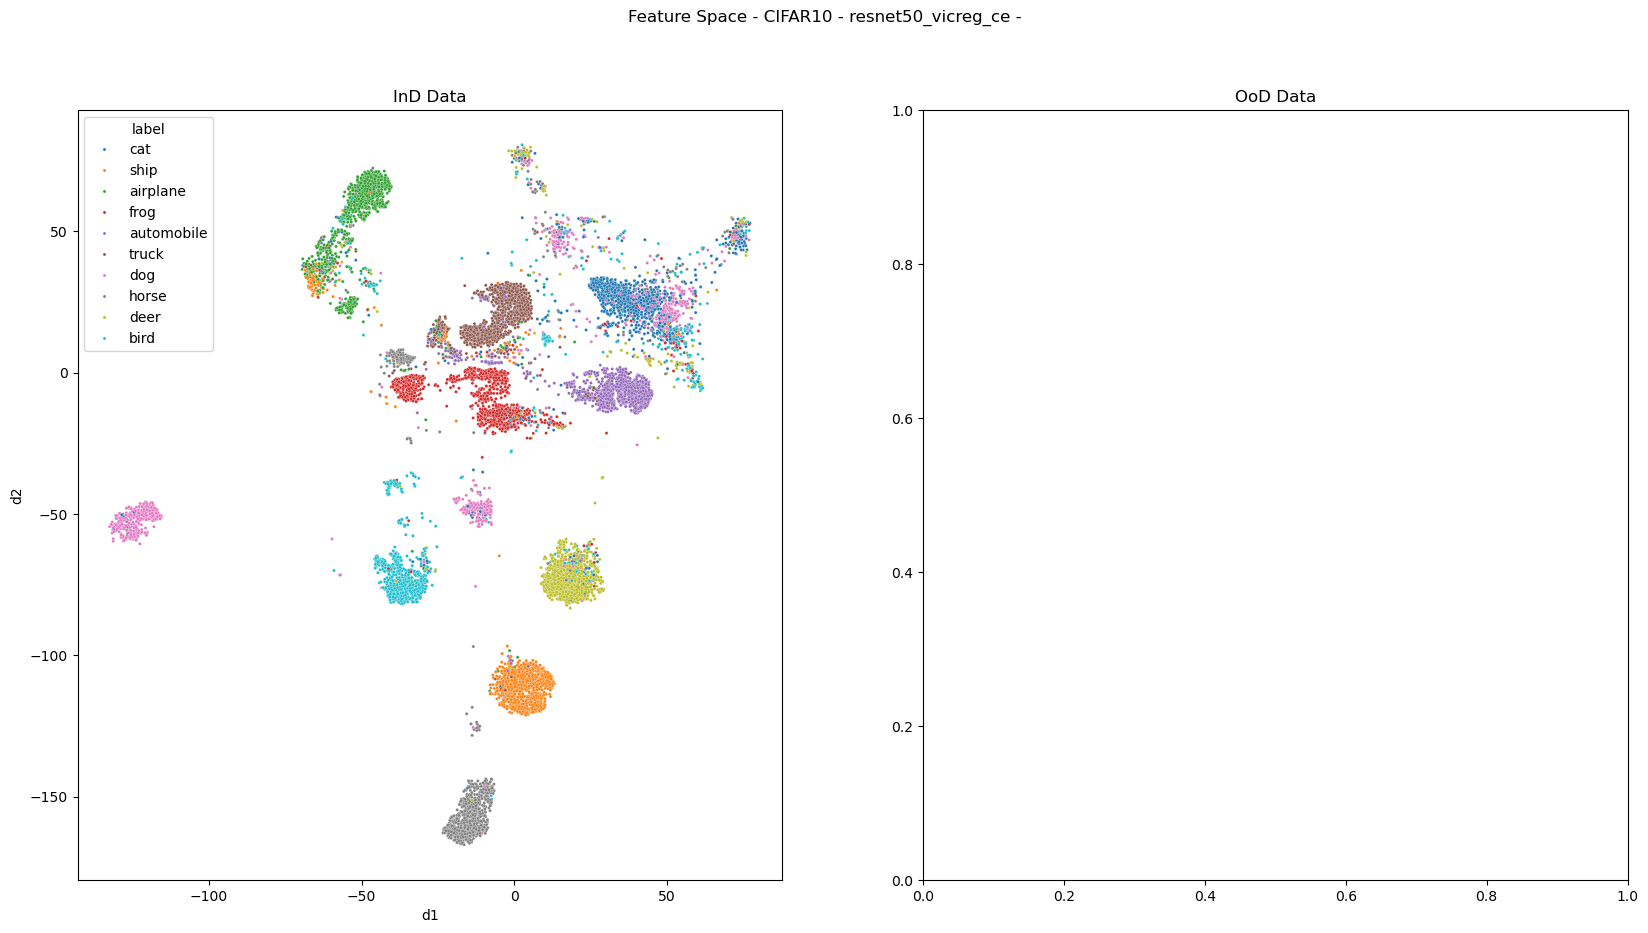

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

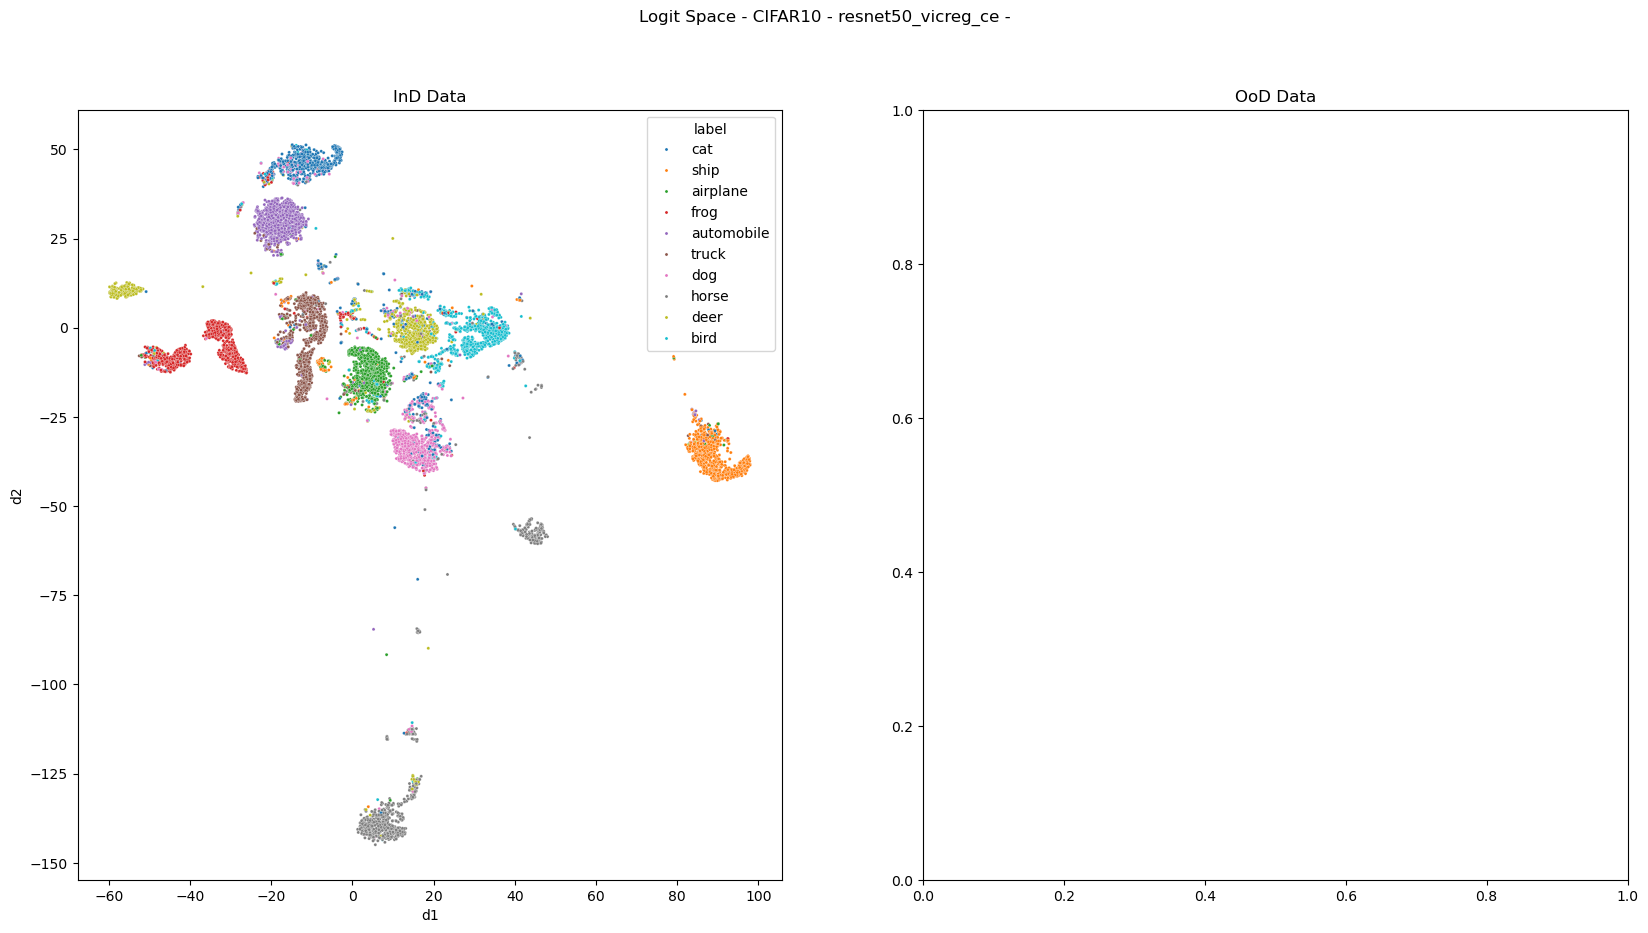

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:08,  2.70s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:05<00:05,  2.77s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:08<00:02,  2.74s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.75s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.75s/it]

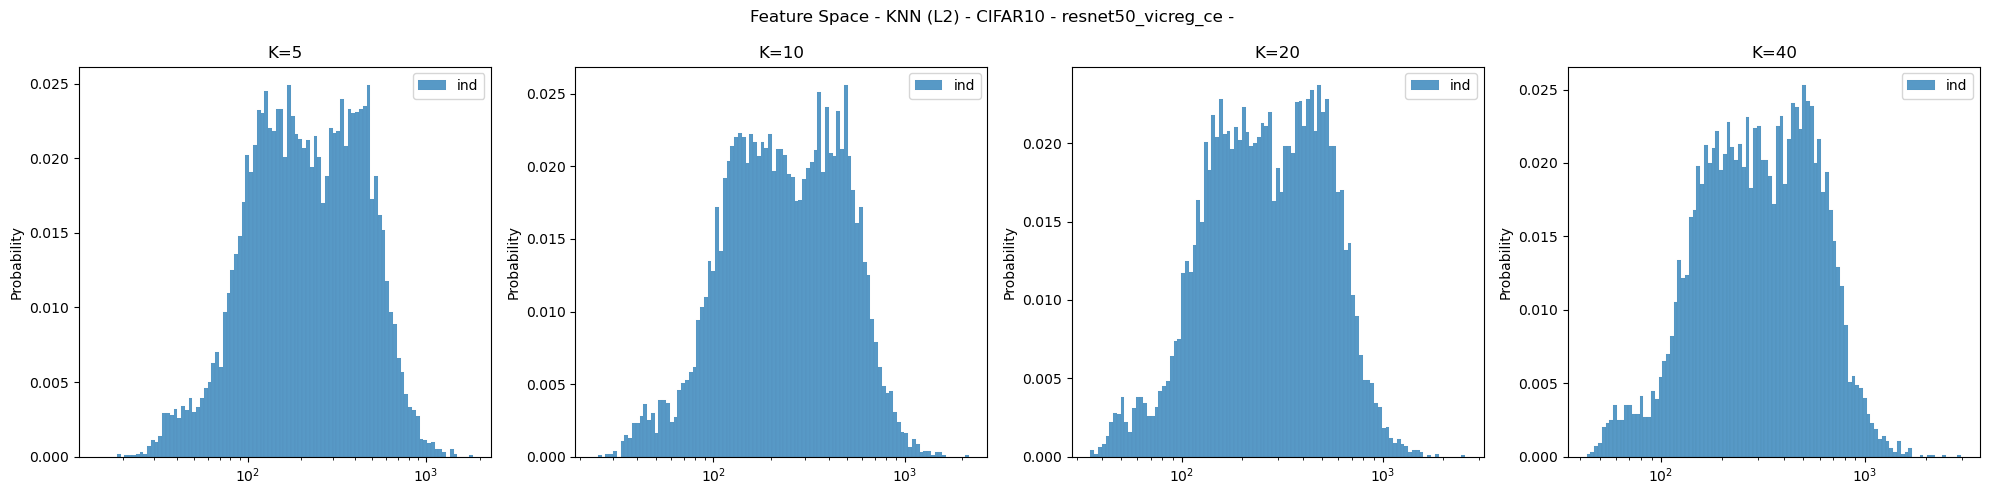

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:07,  2.64s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:05<00:05,  2.65s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:07<00:02,  2.66s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.69s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.67s/it]

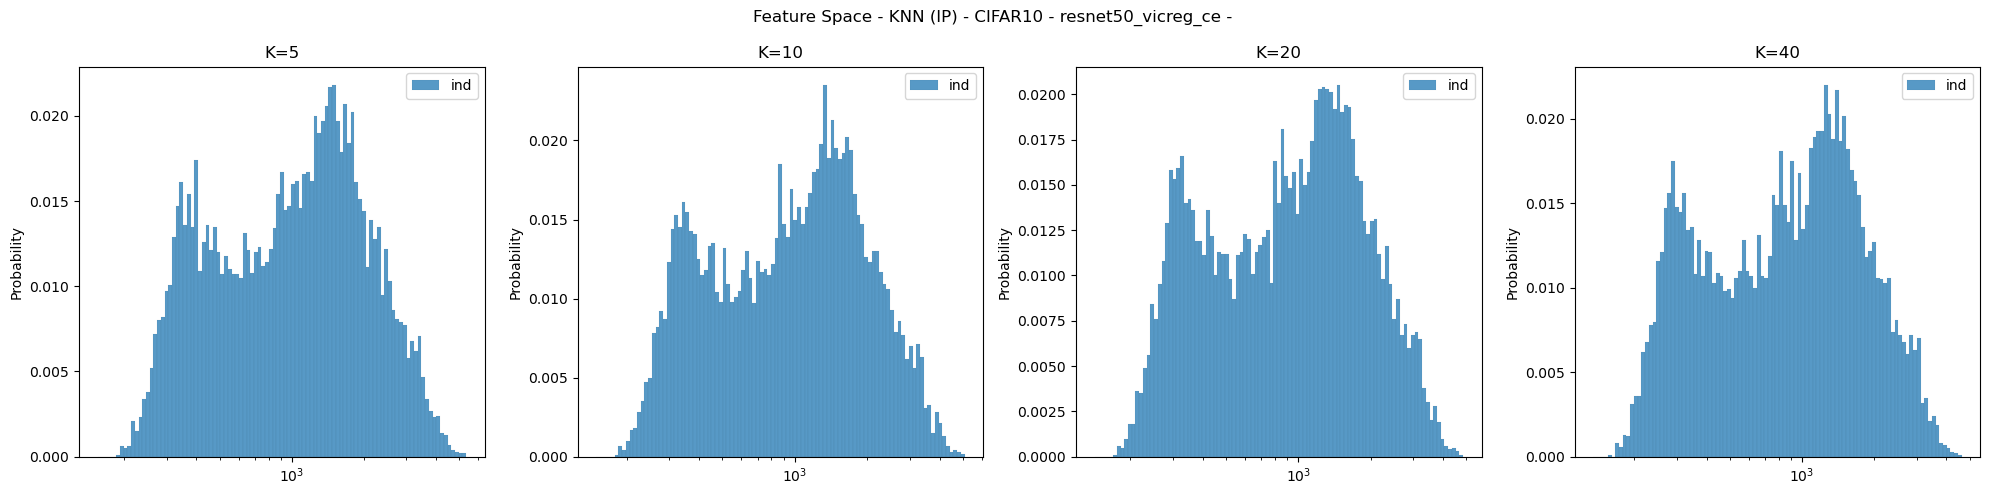

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  5.86it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  5.67it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:00<00:00,  3.56it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.90it/s]

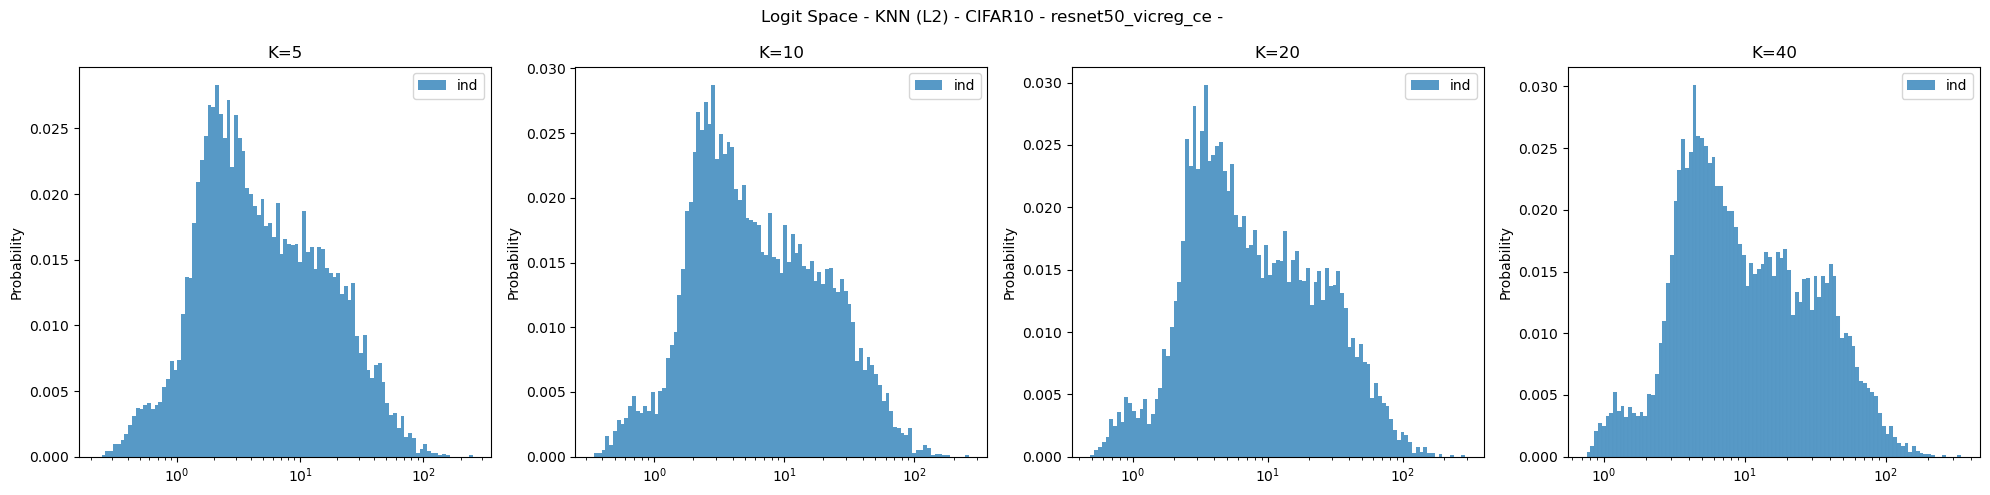

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  6.32it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  6.09it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:00<00:00,  5.66it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.89it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.22it/s]

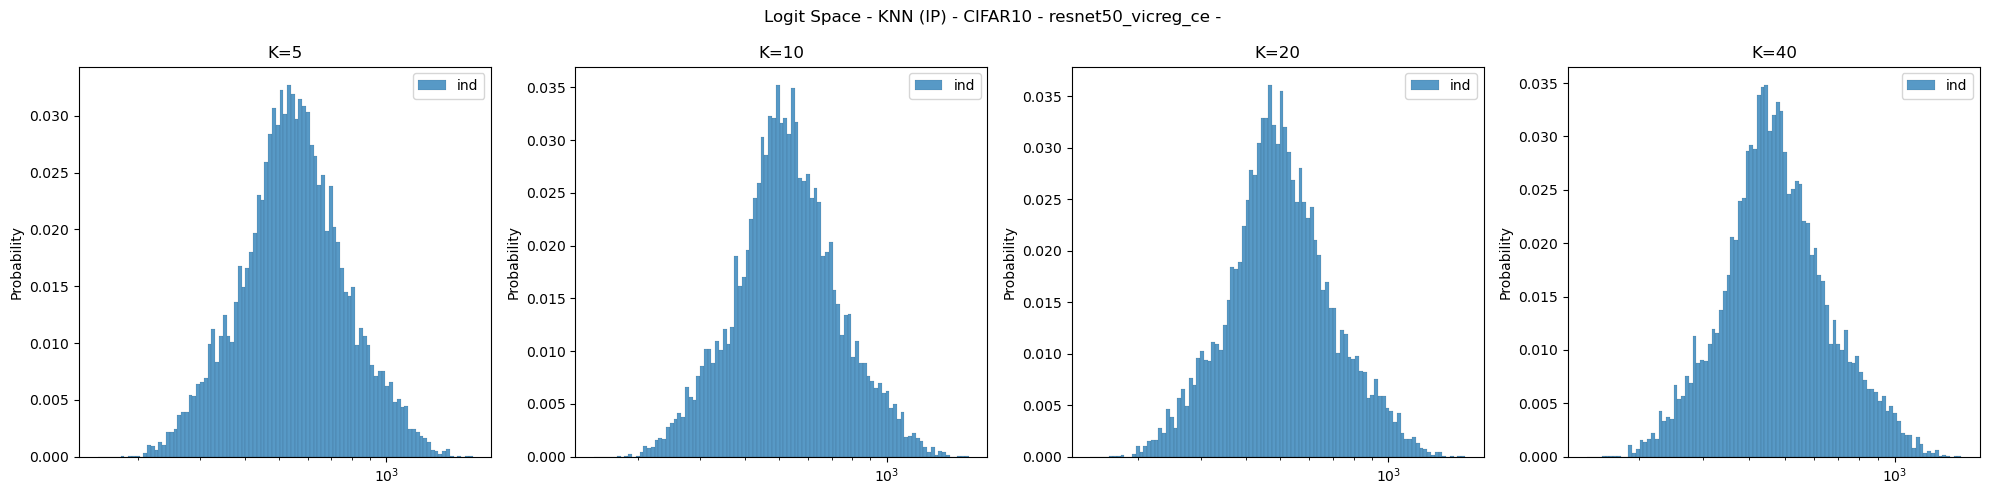

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

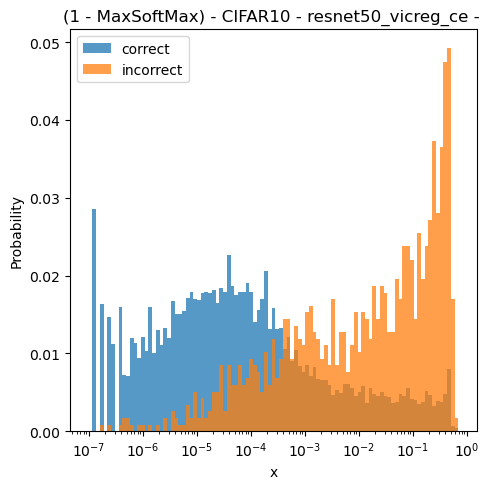

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()